In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
from fastai.vision.all import *
import timm
from the_snake_project.core import *

import wandb
from fastai.callback.wandb import *

In [ ]:
ds.ls()

(#5) [Path('SnakeCLEF2021_train_metadata_PROD.csv'),Path('species_to_country_mapping.csv'),Path('training_data'),Path('training_data.tar.gz'),Path('SnakeCLEF2021_min-train_metadata_PROD.csv')]

In [ ]:
(ds/'training_data').ls()

(#1) [Path('training_data/SnakeCLEF-2021')]

In [ ]:
df = pd.read_csv(ds/'SnakeCLEF2021_min-train_metadata_PROD.csv')

In [ ]:
df['species'] = df.apply(get_species, axis=1)

## Small Baseline with three genus only

We pick the first 10 classes for now:

In [ ]:
df.genus.value_counts()[:10]

Crotalus        4892
Thamnophis      3812
Lampropeltis    3317
Pantherophis    2138
Nerodia         2078
Masticophis     1483
Tantilla        1276
Agkistrodon     1163
Natrix          1145
Micrurus        1092
Name: genus, dtype: int64

In [ ]:
to_consider = L(df.genus.value_counts()[:10].keys().tolist())
to_consider

(#10) ['Crotalus','Thamnophis','Lampropeltis','Pantherophis','Nerodia','Masticophis','Tantilla','Agkistrodon','Natrix','Micrurus']

In [ ]:
df.loc[df.genus.isin(to_consider)]

,binomial,country,continent,genus,family,UUID,source,subset,class_id,image_path,species
314,Agkistrodon bilineatus,Mexico,North America,Agkistrodon,Viperidae,5886ac9538794921a01fa72f05bc3b9e,inaturalist,train,16,/Datasets/SnakeCLEF-2021/inaturalist/5886ac9538794921a01fa72f05bc3b9e.jpg,bilineatus
315,Agkistrodon bilineatus,Mexico,South America,Agkistrodon,Viperidae,8e22f3dcc47944f1908e879932c2dd78,inaturalist,train,16,/Datasets/SnakeCLEF-2021/inaturalist/8e22f3dcc47944f1908e879932c2dd78.jpg,bilineatus
316,Agkistrodon bilineatus,Mexico,North America,Agkistrodon,Viperidae,49bbfbe49e054d78ae6fdb88bc77333c,inaturalist,train,16,/Datasets/SnakeCLEF-2021/inaturalist/49bbfbe49e054d78ae6fdb88bc77333c.jpg,bilineatus
317,Agkistrodon bilineatus,Mexico,North America,Agkistrodon,Viperidae,15077dc0f111406b90102491b34c32d8,inaturalist,train,16,/Datasets/SnakeCLEF-2021/inaturalist/15077dc0f111406b90102491b34c32d8.jpg,bilineatus
318,Agkistrodon bilineatus,Mexico,North America,Agkistrodon,Viperidae,44f7023633aa4eaeaba451c554227b76,inaturalist,train,16,/Datasets/SnakeCLEF-2021/inaturalist/44f7023633aa4eaeaba451c554227b76.jpg,bilineatus
...,...,...,...,...,...,...,...,...,...,...,...
64815,Thamnophis validus,Mexico,North America,Thamnophis,Colubridae,608be24d6f794fc59a580aba5eb8e2cc,inaturalist,train,707,/Datasets/SnakeCLEF-2021/inaturalist/608be24d6f794fc59a580aba5eb8e2cc.jpg,validus
64816,Thamnophis validus,unknown,unknown,Thamnophis,Colubridae,f5be91ca05b14082819234d3434b2993,inaturalist,train,707,/Datasets/SnakeCLEF-2021/inaturalist/f5be91ca05b14082819234d3434b2993.jpg,validus
64817,Thamnophis validus,Mexico,North America,Thamnophis,Colubridae,6a27f176e09d4ebfa4ed62f9f031f938,inaturalist,train,707,/Datasets/SnakeCLEF-2021/inaturalist/6a27f176e09d4ebfa4ed62f9f031f938.jpg,validus
64818,Thamnophis validus,Mexico,South America,Thamnophis,Colubridae,1c9bdcf913684ebda0c5b6fc64394cde,inaturalist,train,707,/Datasets/SnakeCLEF-2021/inaturalist/1c9bdcf913684ebda0c5b6fc64394cde.jpg,validus


In [ ]:
small_df = df.loc[df.genus.isin(to_consider)]

In [ ]:
item_tfms=[Resize(224)]
batch_tfms = [*aug_transforms()]

In [ ]:
dls = get_dls(small_df, get_x, get_y_gns, item_tfms, batch_tfms)

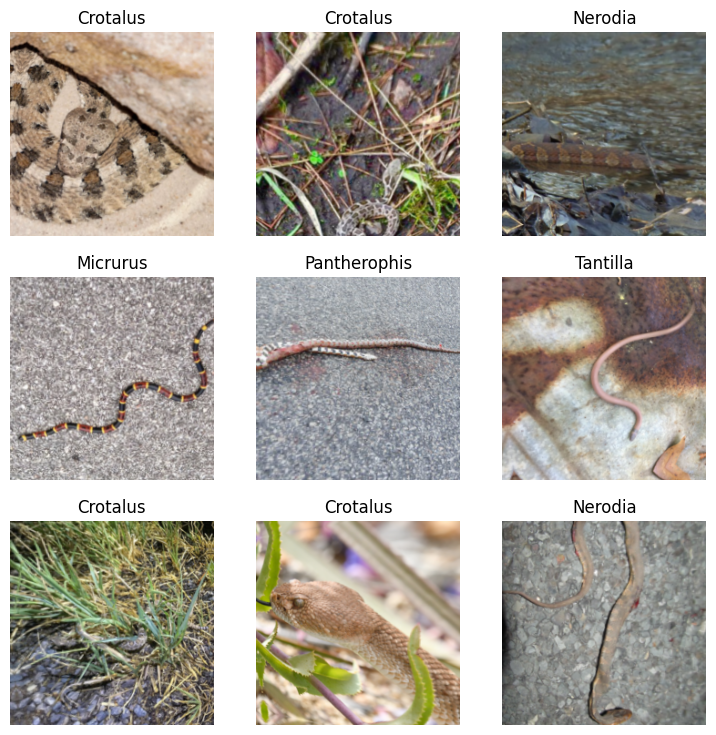

In [ ]:
dls.show_batch()

In [ ]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge']

In [ ]:
learn = vision_learner(dls, "convnext_base", metrics=[error_rate, accuracy]).to_fp16()

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0008317637839354575)

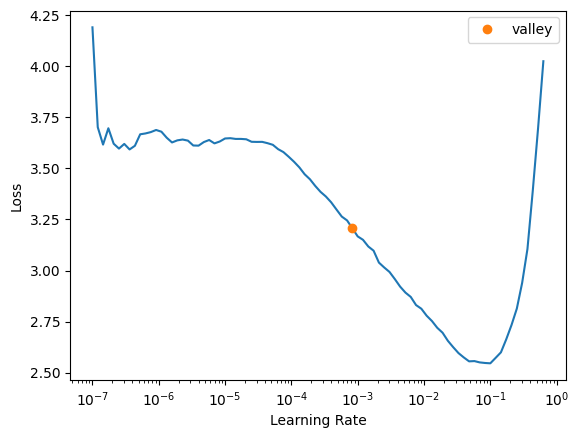

In [ ]:
learn.lr_find()

In [ ]:
wandb.init(project='the-snake-project-cls', name='cls10-cnxt-base')
learn.fit_one_cycle(10, 1e-3, cbs=[WandbCallback()])

wandb.finish(quiet=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.497123,0.998827,0.314802,0.685198,02:09
1,1.062886,0.801144,0.263452,0.736548,02:10
2,0.823819,0.659676,0.230185,0.769815,02:10
3,0.727598,0.629654,0.221255,0.778745,02:10
4,0.646740,0.603376,0.213664,0.786336,02:10
5,0.590586,0.575120,0.205850,0.794150,02:10
6,0.528360,0.551575,0.196026,0.803974,02:10
7,0.493793,0.540961,0.192454,0.807546,02:10
8,0.440384,0.537064,0.188212,0.811788,02:10
9,0.436310,0.530151,0.186426,0.813574,02:10


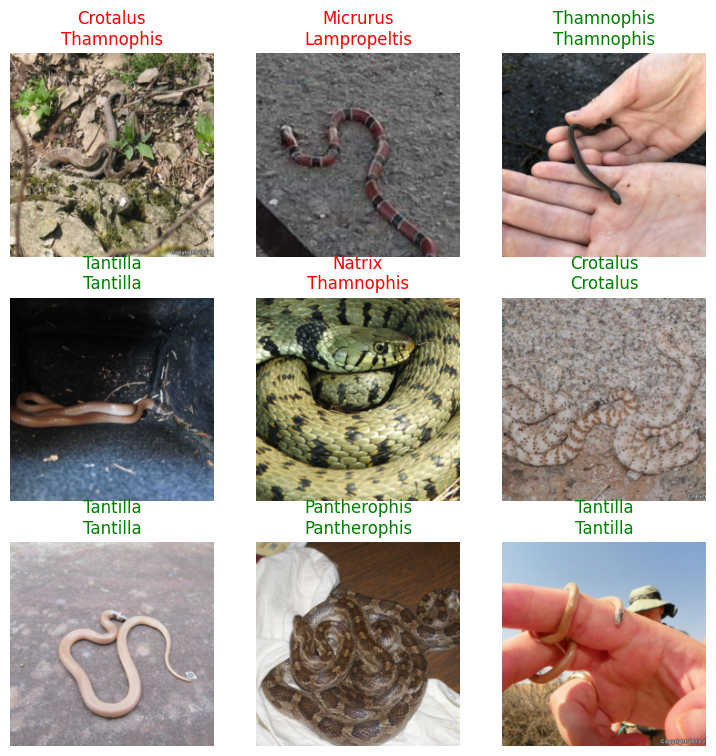

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

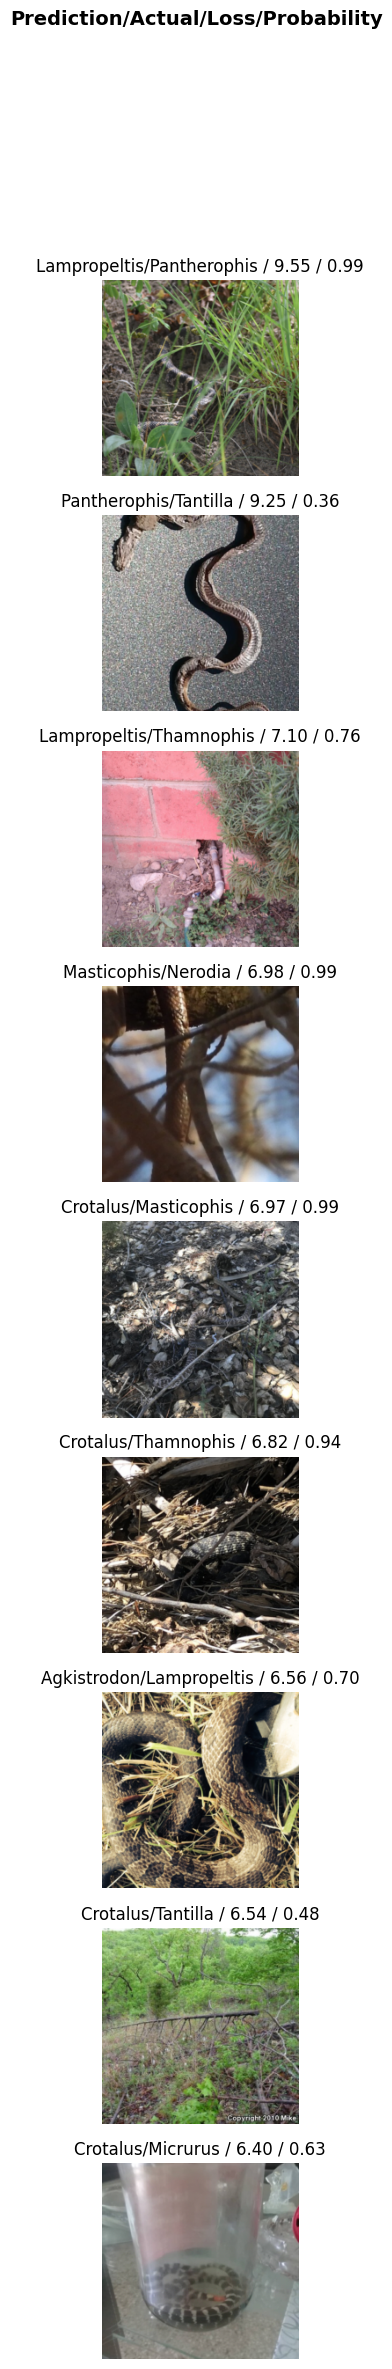

In [ ]:
interp.plot_top_losses(k=9, nrows=9)

In [ ]:
interp.most_confused(9)

[('Pantherophis', 'Lampropeltis', 75),
 ('Micrurus', 'Lampropeltis', 42),
 ('Lampropeltis', 'Pantherophis', 39),
 ('Masticophis', 'Thamnophis', 36),
 ('Agkistrodon', 'Nerodia', 34),
 ('Pantherophis', 'Crotalus', 32),
 ('Nerodia', 'Crotalus', 31),
 ('Natrix', 'Thamnophis', 30),
 ('Thamnophis', 'Masticophis', 29),
 ('Natrix', 'Nerodia', 28),
 ('Lampropeltis', 'Crotalus', 25),
 ('Crotalus', 'Pantherophis', 24),
 ('Nerodia', 'Thamnophis', 23),
 ('Agkistrodon', 'Crotalus', 22),
 ('Thamnophis', 'Nerodia', 21),
 ('Pantherophis', 'Masticophis', 20),
 ('Thamnophis', 'Crotalus', 20),
 ('Natrix', 'Crotalus', 19),
 ('Nerodia', 'Agkistrodon', 17),
 ('Nerodia', 'Lampropeltis', 17),
 ('Crotalus', 'Lampropeltis', 16),
 ('Natrix', 'Masticophis', 16),
 ('Lampropeltis', 'Micrurus', 15),
 ('Pantherophis', 'Thamnophis', 15),
 ('Masticophis', 'Crotalus', 14),
 ('Thamnophis', 'Pantherophis', 14),
 ('Crotalus', 'Nerodia', 13),
 ('Nerodia', 'Natrix', 13),
 ('Tantilla', 'Thamnophis', 13),
 ('Thamnophis', 'Lampr